### Overview of the Benchmark Analysis:

This Jupyter Notebook documents the process of conducting multiple sentiment analyses using various models and benchmarking their performance to determine the most suitable model for our predictive modeling. To recreate the graphs, etc., you just have to click on "Run All"

1. **Sentiment Analysis:**
   - We performed a sentiment analysis using four different models on the reviews:
     - **VADER**
     - **Textblob**
     - **SieBERT & DistilBERT**
     - **OpenAI**

2. **Method Invocation:**
   - For each sentiment analysis, we invoked specific methods from various model related .py files
   - For Vader and Textblob, we conducted the sentiment analysis both on preprocessed and unpreprocessed reviews

3. **Benchmark Analysis:**
   - After completing the sentiment analyses, we conducted a benchmark analysis:
     - Retrieved manually annotated comments to serve as a ground truth
     - Calculated key performance metrics for each model, including accuracy, precision, recall, and F1 score

4. **Model Selection:**
   - Based on the benchmark analysis, we identified the best-performing model
   - The selected model's sentiment predictions were integrated as an additional variable into the overall model for further analysis

5. **Key Findings from Benchmark Analysis:**
    - **OpenAI Model:**
      - Demonstrated the highest performance across all metrics: accuracy, precision, recall, and F1 score
      
    - **SieBERT & DistilBERT Models:**
      - Showed similar accuracy to OpenAI but lagged behind in other metrics

    - **TextBlob and VADER Models:**
      - Underperformed in all metrics
      - Predicted a disproportionately high percentage of positive sentiments, which was inconsistent with our manually labeled data
      - Textblob also predicted a high proportion of neutral sentiments, leading to the lowest accuracy among all models


In [1]:
# Import all the libraries and modules required for the further analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentiment_analysis_vader import *
from sentiment_analysis_textblob import *
from sentiment_analysis_openai import *
from sentiment_analysis_bert import *
from benchmarking_helper_functions import *
import os
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from nlp.comments_preprocessing import *

c:\Users\Niklas Kothe\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Load the CSV files
data,comments = read_dataframes()

#### **Sentiment Analysis with VADER**

In [3]:
# Copy the original comments DataFrame to avoid modifying the original data
comments_vader = comments.copy()

# Add sentiment scores to the copied DataFrame for both original and cleaned comments
comments_vader = vader_add_sentiment_scores(comments_vader, 'Comment', 'cleaned_Comment')

# Apply the final_sentiment function to the 'compound' column to categorize sentiment
comments_vader["sentiment"] = comments_vader["compound"].apply(lambda x: vader_final_sentiment(x))

# Apply the final_sentiment function to the 'compound_cleaned' column to categorize cleaned sentiment
comments_vader["sentiment_cleaned"] = comments_vader["compound_cleaned"].apply(lambda x: vader_final_sentiment(x))

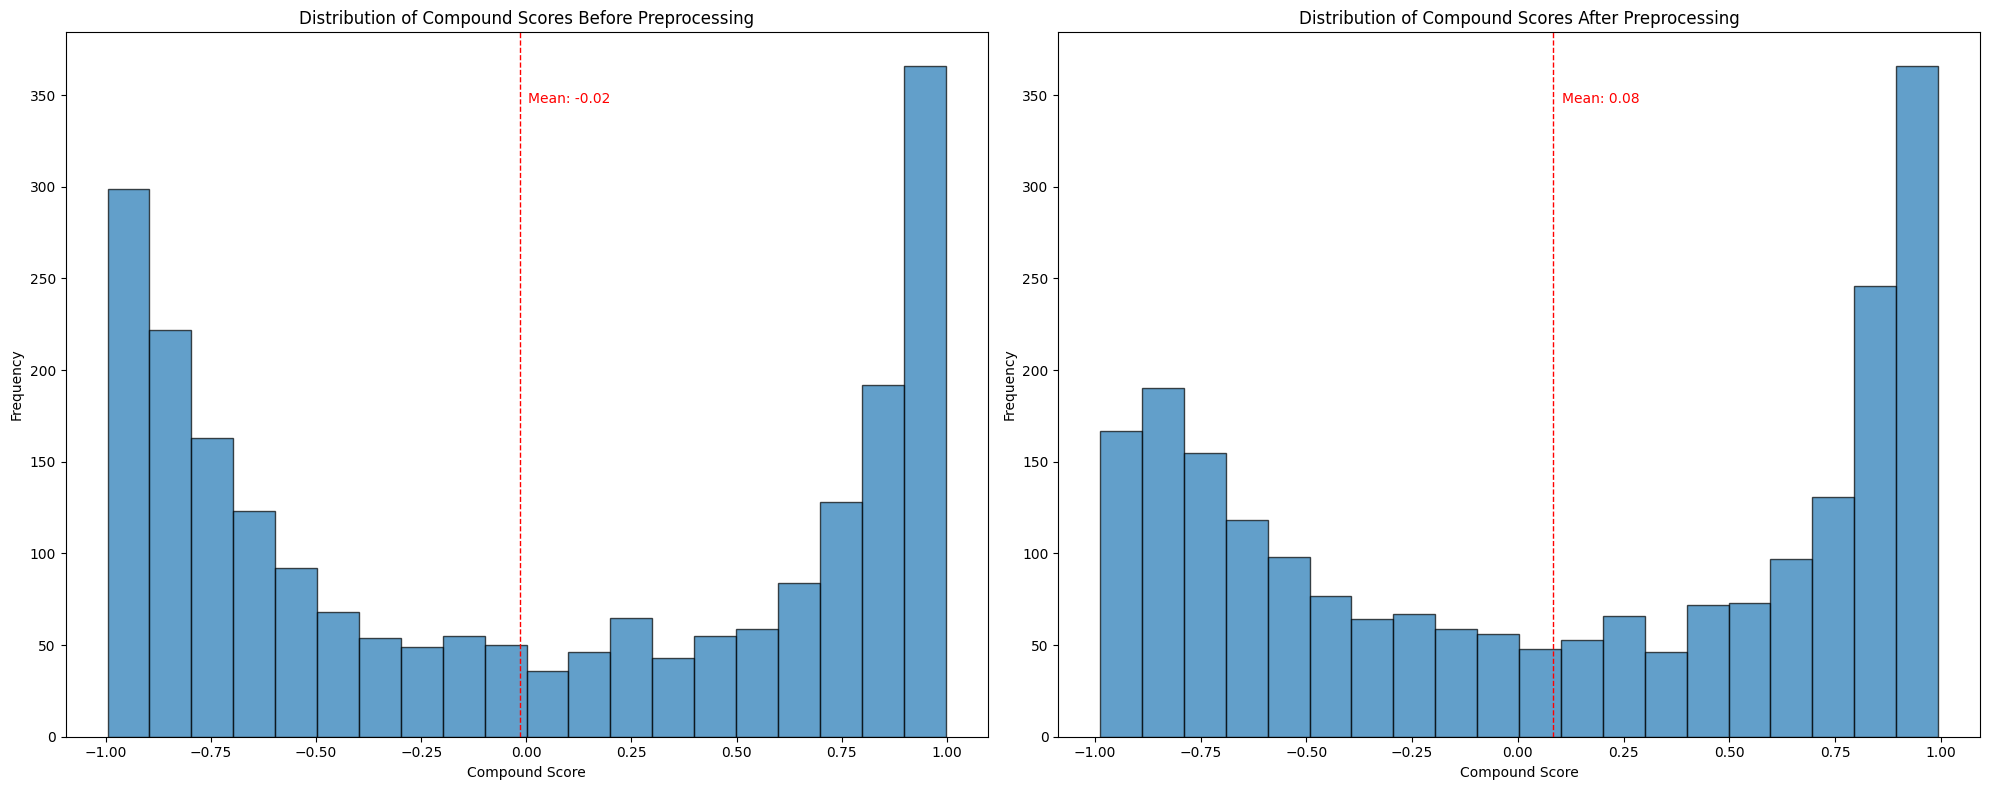

In [4]:
# Plot Sentiment Distributions for Vader Compound Scores
vader_plot_sentiment_distributions(comments_vader)

##### Distribution of Vader Compound Scores Before and After Preprocessing
- The left histogram shows the distribution of compound scores before preprocessing
  - The distribution is bimodal, with peaks around -1.0 and 1.0
  - It indicates a high frequency of both negative and positive sentiments in the raw data
- The right histogram shows the distribution of compound scores after preprocessing
  - The distribution remains bimodal but shows a slightly smoother spread across compound scores
  - Preprocessing appears to have moderated some of the more negative scores while maintaining the rest of the sentiment distribution (the mean is slightly larger)

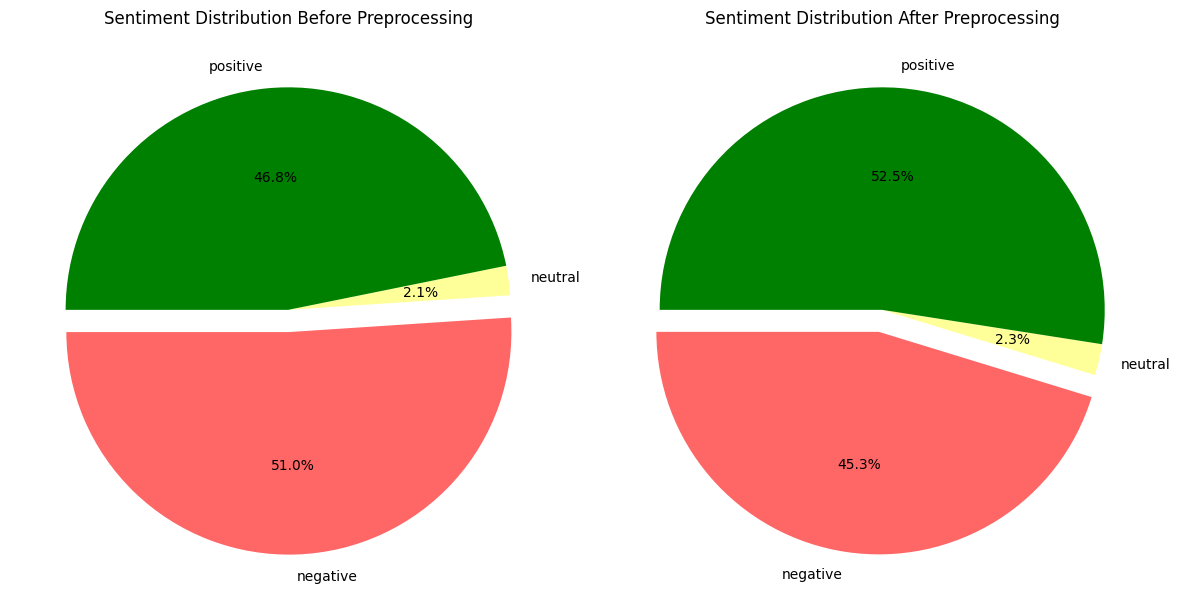

In [5]:
# Plot the sentiment proportions for both original and cleaned sentiment labels
vader_plot_sentiment_proportions(comments_vader, "sentiment", "sentiment_cleaned")

##### Vader Sentiment Distribution Before and After Preprocessing:
- The left pie chart represents the sentiment distribution before preprocessing
- The right pie chart represents the sentiment distribution after preprocessing.
- Preprocessing has reduced the proportion of negative sentiments and increased the proportion of positive sentiments slightly (that is in line with the previous finding)

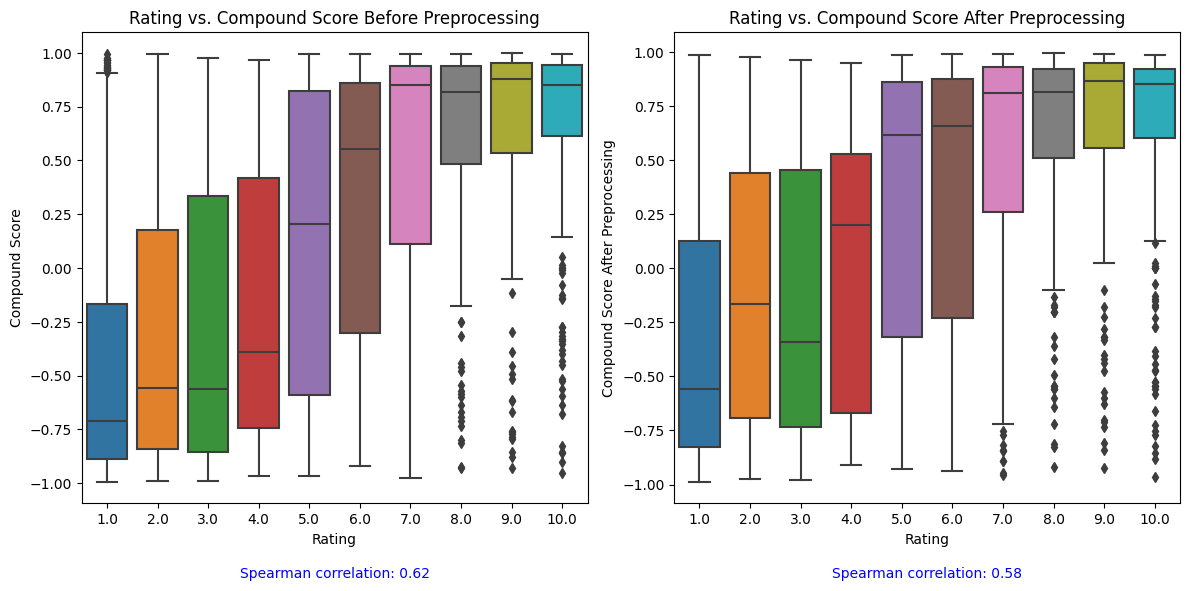

In [6]:
# Plot the compound score against the rating
vader_plot_rating_vs_compound(data, comments_vader)

##### Rating vs. Vader Compound Score Before and After Preprocessing
- The left box plot shows the relationship between ratings and compound scores before preprocessing
  - Higher ratings generally correspond to higher compound scores, indicating positive sentiment
  - Lower ratings correspond to lower compound scores, indicating negative sentiment
- The right box plot shows the relationship between ratings and compound scores after preprocessing
  - The trend remains similar, with high ratings associated with high compound scores and vice versa
- However, preprocessing has slightly decreased the correlation between ratings and compound scores, as some of the negative comments were moderated through the preprocessing

#### **Sentiment Analysis with Textblob**

In [7]:
# Copy the original comments DataFrame to avoid modifying the original data
comments_textblob = comments.copy()

In [8]:
# Apply TextBlob sentiment analysis to the 'Comment' column
comments_textblob['polarity'], comments_textblob['subjectivity'] = zip(*comments_textblob['Comment'].apply(textblob_sentiment))

# Apply TextBlob sentiment analysis to the 'cleaned_Comment' column
comments_textblob['cleaned_polarity'], comments_textblob['cleaned_subjectivity'] = zip(
    *comments_textblob['cleaned_Comment'].apply(textblob_sentiment))

# The textblob_final_sentiment function maps polarity scores to sentiment categories
comments_textblob["polarity_group"] = comments_textblob["polarity"].apply(lambda compound: textblob_final_sentiment(compound))

# Group the polarity scores into sentiment categories for the cleaned comments
comments_textblob["polarity_group_cleaned"] = comments_textblob["cleaned_polarity"].apply(lambda compound: textblob_final_sentiment(compound))

# Group the subjectivity scores into categories for the original comments
comments_textblob["subjectivity_group"] = comments_textblob["subjectivity"].apply(lambda compound: textblob_final_subjectivity(compound))

# Group the subjectivity scores into categories for the cleaned comments
comments_textblob["subjectivity_group_cleaned"] = comments_textblob["cleaned_subjectivity"].apply(
    lambda compound: textblob_final_subjectivity(compound))

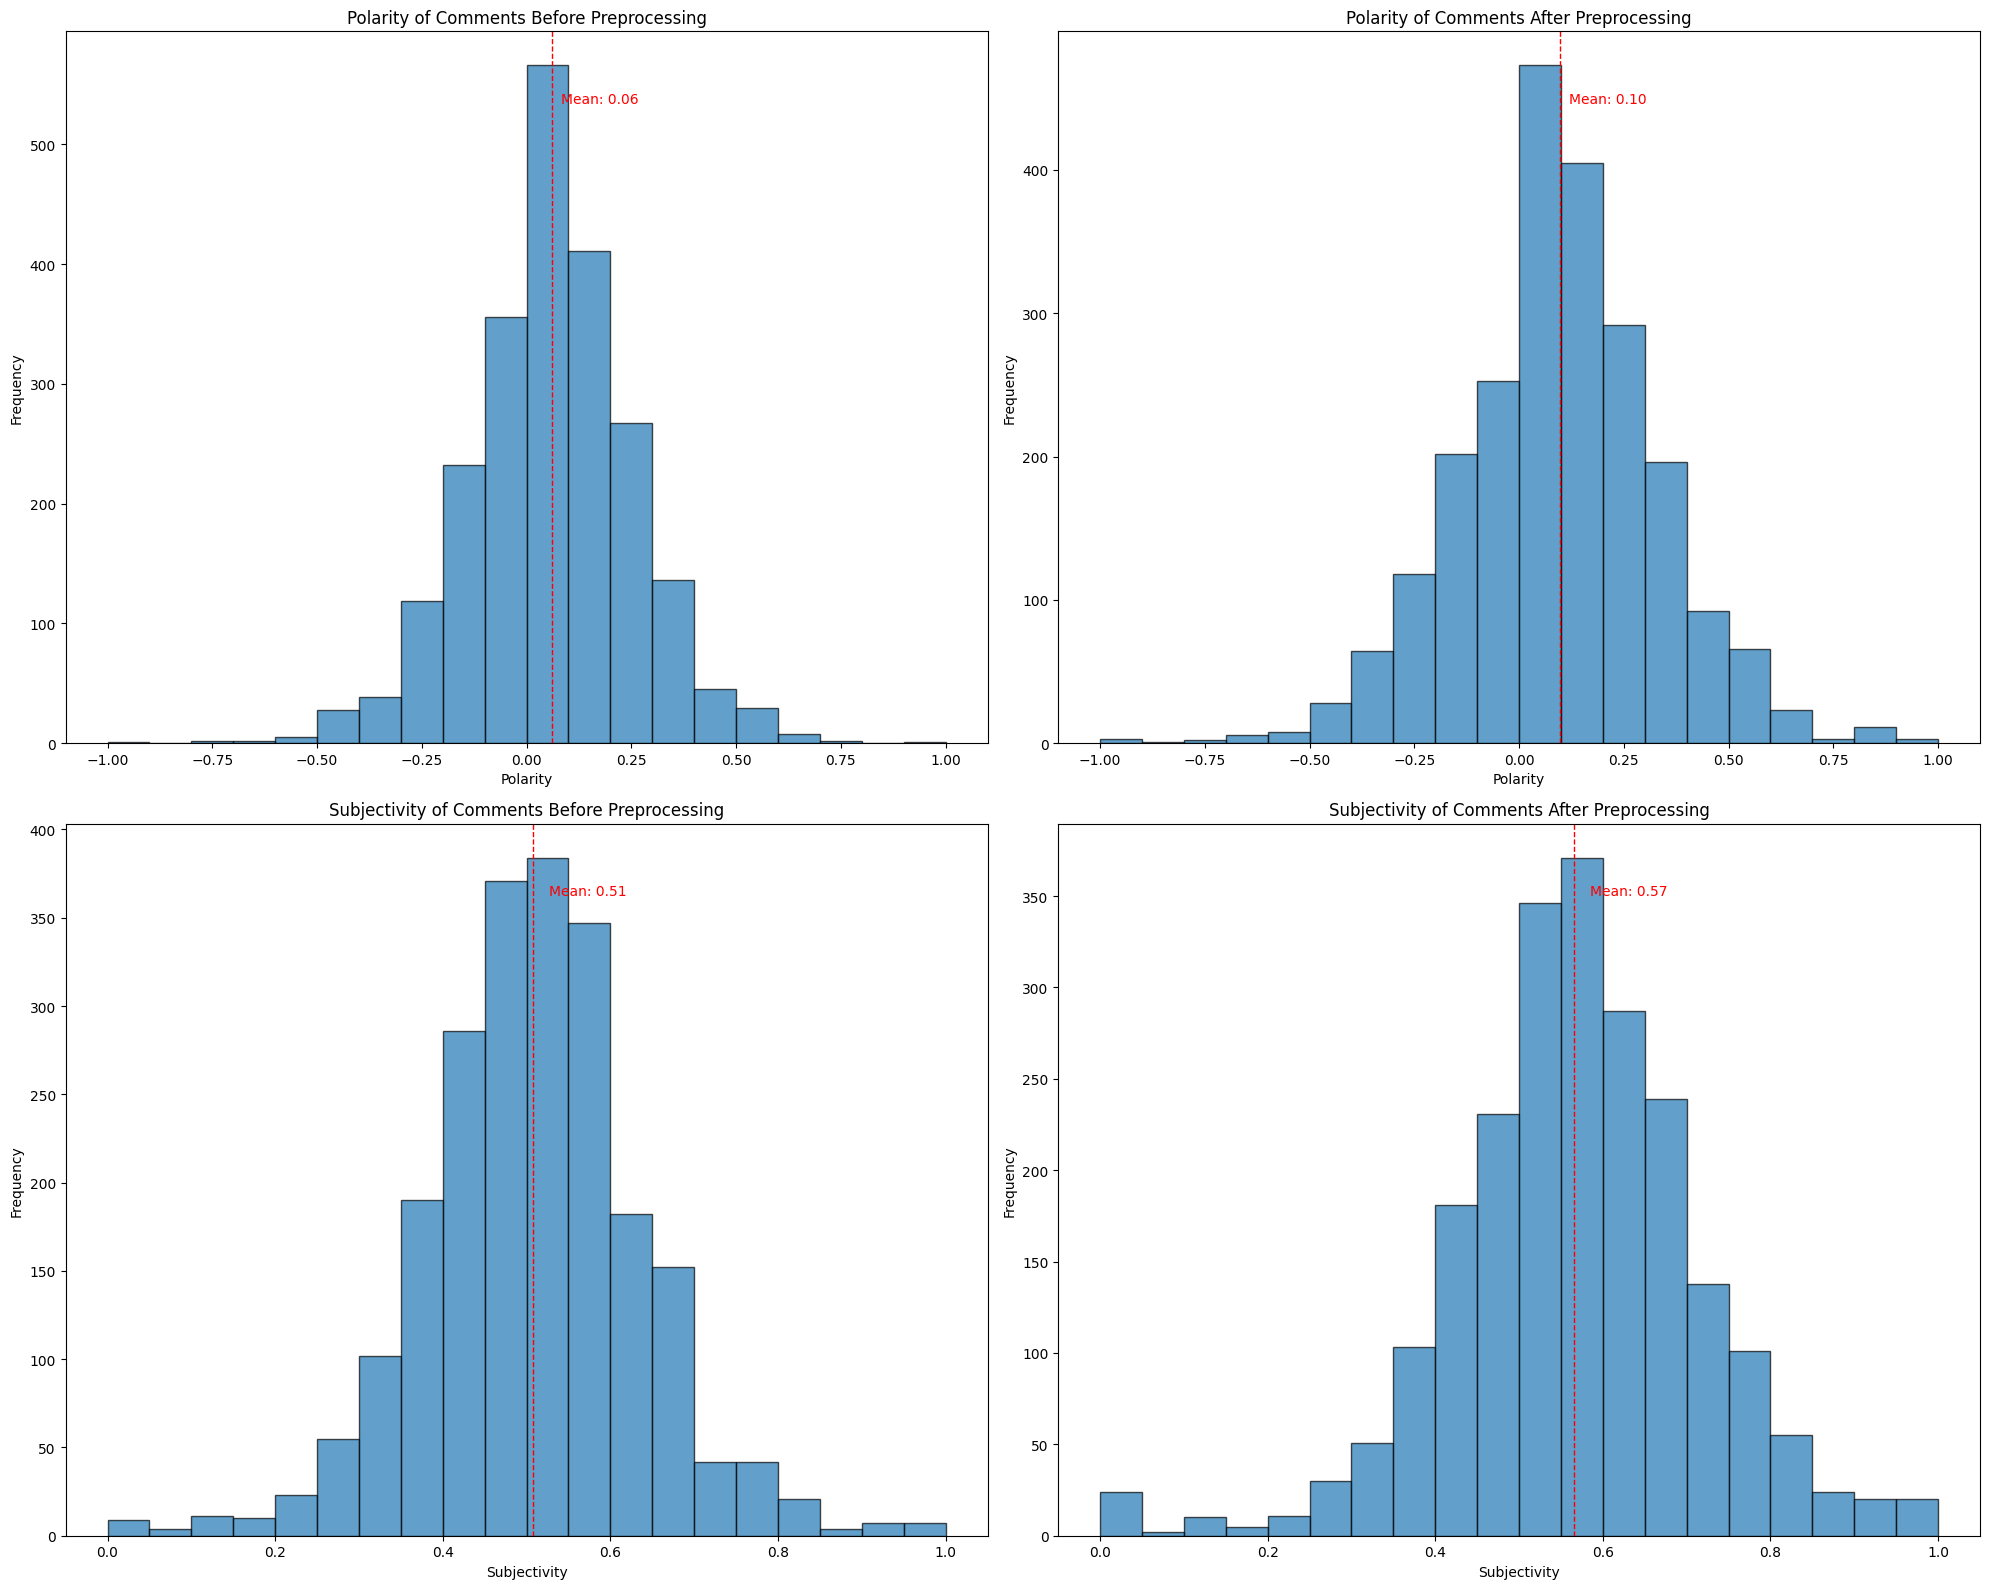

In [9]:
# Plot the distribution of sentiment scores using TextBlob analysis
textblob_plot_score_distribution(comments_textblob)

##### Distribution of Textblob Polarity and Subjectivity Scores Before and After Preprocessing:
- The top row shows the distribution of polarity scores (ranges from -1 to 1):
  - Before preprocessing: Polarity scores are centered around 0, indicating a mix of positive and negative sentiments, but most of them neutral.
  - After preprocessing: The distribution remains centered around 0 without noticeable changes (but the overall mean is a bit larger)
- The bottom row shows the distribution of subjectivity scores: (ranges from 0 to 1):
  - Before preprocessing: Subjectivity scores are fairly distributed around 0.5
  - After preprocessing: The distribution shifts slightly towards higher subjectivity

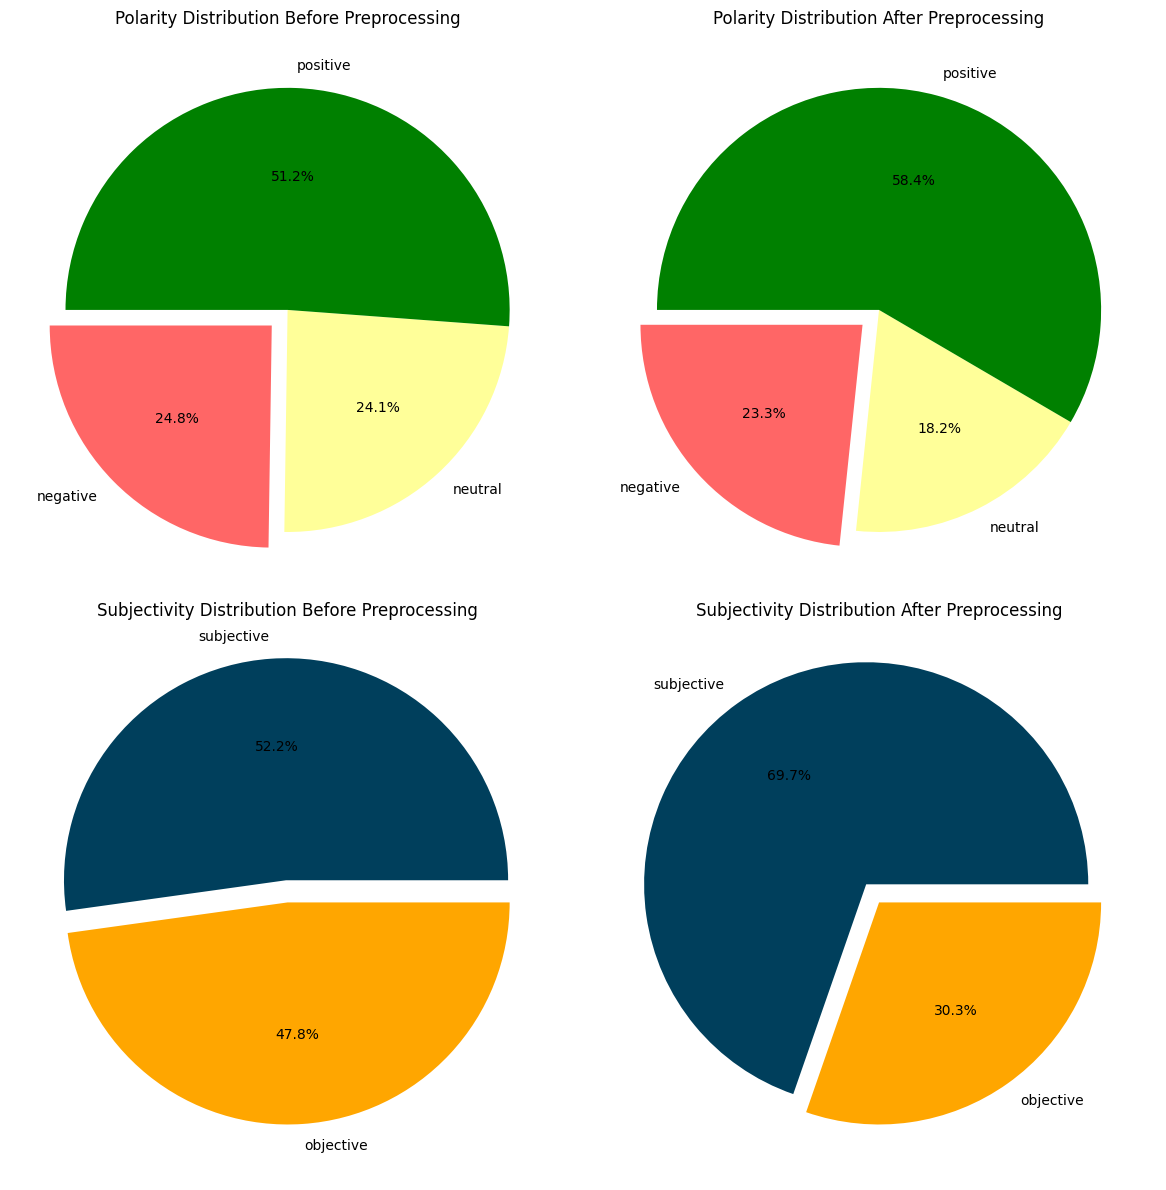

In [10]:
textblob_plot_pie_distribution(comments_textblob)

##### Textblob Polarity and Subjectivity Distribution Before and After Preprocessing:
- The top row shows the polarity distribution:
  - Preprocessing has increased the proportion of positive sentiments and reduced neutral sentiments
- The bottom row shows the subjectivity distribution:
  - Preprocessing has increased the proportion of subjective comments significantly

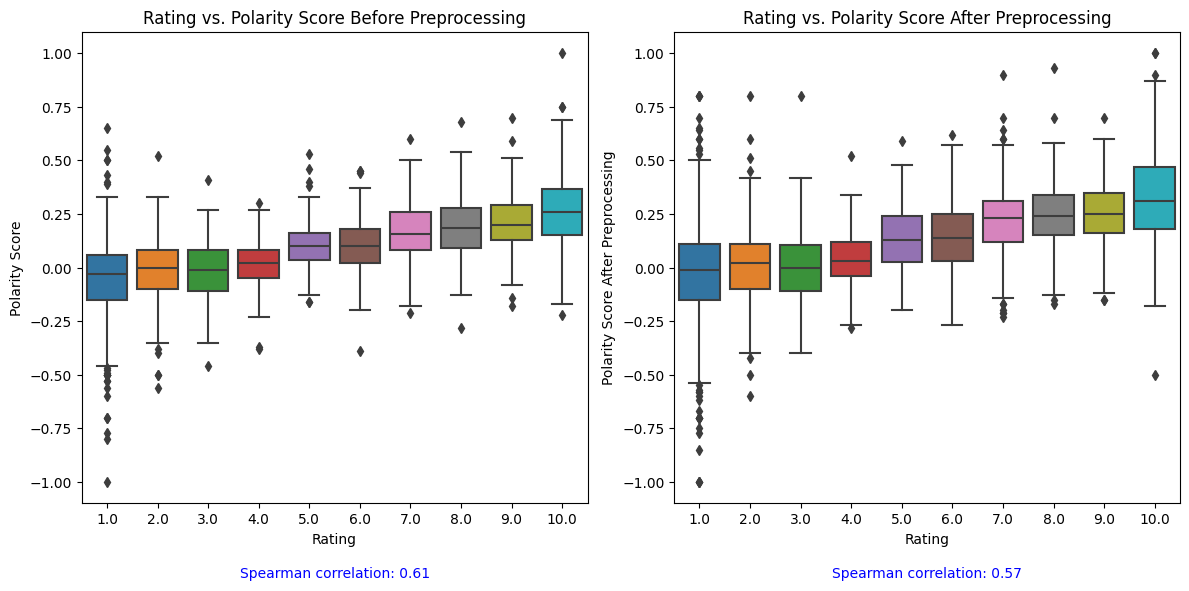

In [11]:
# Plot the polarity scores against the rating
textblob_analyze_ratings_vs_sentiment(data, comments_textblob)

##### Rating vs. Textblob Polarity Score Before and After Preprocessing:
- The left box plot illustrates the relationship between ratings and polarity scores before preprocessing
- The right box plot illustrates the relationship between ratings and polarity scores after preprocessing
- Preprocessing has slightly reduced the correlation between ratings and polarity scores, but the overall relationship remains robust
- The median polarity scores increase only slightly with higher ratings
- If a line were drawn through the medians of the different box plots, it would show a slight upward trend, unlike the more pronounced positive trend observed in the Vader analysis

#### **Sentiment Analysis with OpenAI**

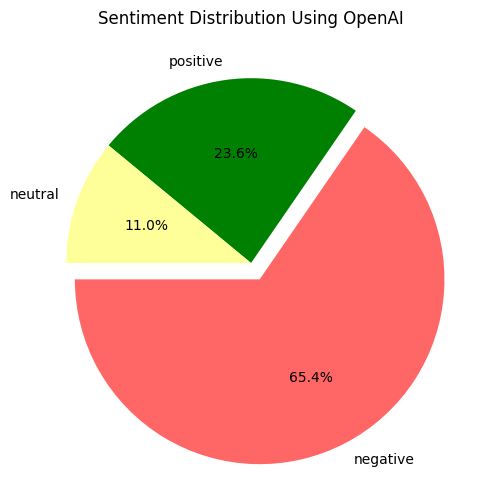

In [12]:
# Read the CSV file in the data folder
comments_openai = read_openai_sentiment_data()

# Plot the proportions of sentiments
openai_plot_sentiment_proportions(comments_openai, "openai_sentiment")

##### OpenAI Sentiment Distribution:

- The distribution is skewed towards the negative sentiment, with a significant majority of the reviews falling into the negative category
- The presence of positive and neutral sentiments is relatively lower (also compared to the previous distributions), highlighting that the overall sentiment trend is more negative

#### **Sentiment Analysis with BERT (DistilBERT and SieBERT)**

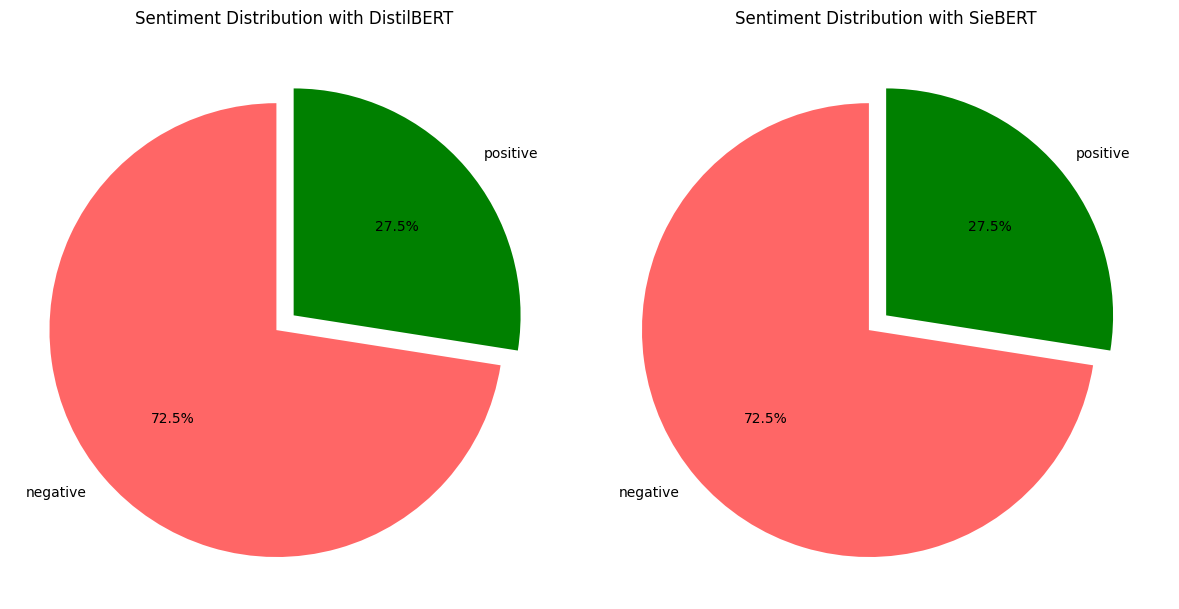

In [13]:
# Read the data in a data frame
comments_bert = read_bert_sentiment_data()

# Plot the proportions
bert_plot_sentiment_proportions(comments_bert, "sentiment_comment_distilbert", "sentiment_comment_siebert")

##### Sentiment Distribution with DistilBERT and SieBERT:

- Note that there is no neutral segment because the models chosen (DistilBERT and SieBERT) do not classify sentiments into a neutral category
- Both models, DistilBERT and SieBERT, show a predominant negative sentiment in the data, with the same distribution of 72.5% negative and 27.5% positive sentiments
- The proportions are similar to the ones from the OpenAI Analysis (but as you can see without the neutral category)


#### **Benchmark Analysis**

In [14]:
# Preprocess Vader Sentiment
# Map the sentiment values to numerical values
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
comments_vader["vader_sentiment"] = comments_vader["sentiment"].map(sentiment_mapping)
comments_vader["vader_sentiment_preprocessed"] = comments_vader["sentiment_cleaned"].map(sentiment_mapping)

# Create a new DataFrame with the required columns
vader_sentiments_df = comments_vader[["Comment", "vader_sentiment", "vader_sentiment_preprocessed"]]

# Preprocess TextBlob Sentiment
# Map the sentiment values to numerical values
comments_textblob["textblob_sentiment"] = comments_textblob["polarity_group"].map(sentiment_mapping)
comments_textblob["textblob_sentiment_preprocessed"] = comments_textblob["polarity_group_cleaned"].map(sentiment_mapping)

# Create a new DataFrame with the required columns
textblob_sentiments_df = comments_textblob[["Comment", "textblob_sentiment", "textblob_sentiment_preprocessed"]]

# Create a DataFrame for OpenAI Sentiment
openai_sentiments_df = comments_openai[["Comment", "openai_sentiment"]]

# Preprocess BERT Sentiments
# Map the sentiment values to numerical values for BERT models
sentiment_mapping_bert = {"POSITIVE": 1, "NEGATIVE": -1, "NEUTRAL": 0}
comments_bert["distilBERT_sentiment"] = comments_bert["sentiment_comment_distilbert"].map(sentiment_mapping_bert)
comments_bert["sieBERT_sentiment"] = comments_bert["sentiment_comment_siebert"].map(sentiment_mapping_bert)

# Create a new DataFrame with the required columns
bert_sentiments_df = comments_bert[["Comment", "distilBERT_sentiment", "sieBERT_sentiment"]]

# Merge all sentiment DataFrames on the "Comment" column
merged_sentiments_df = pd.merge(vader_sentiments_df, textblob_sentiments_df, on="Comment", how="outer")
merged_sentiments_df = pd.merge(merged_sentiments_df, openai_sentiments_df, on="Comment", how="outer")
merged_sentiments_df = pd.merge(merged_sentiments_df, bert_sentiments_df, on="Comment", how="outer")


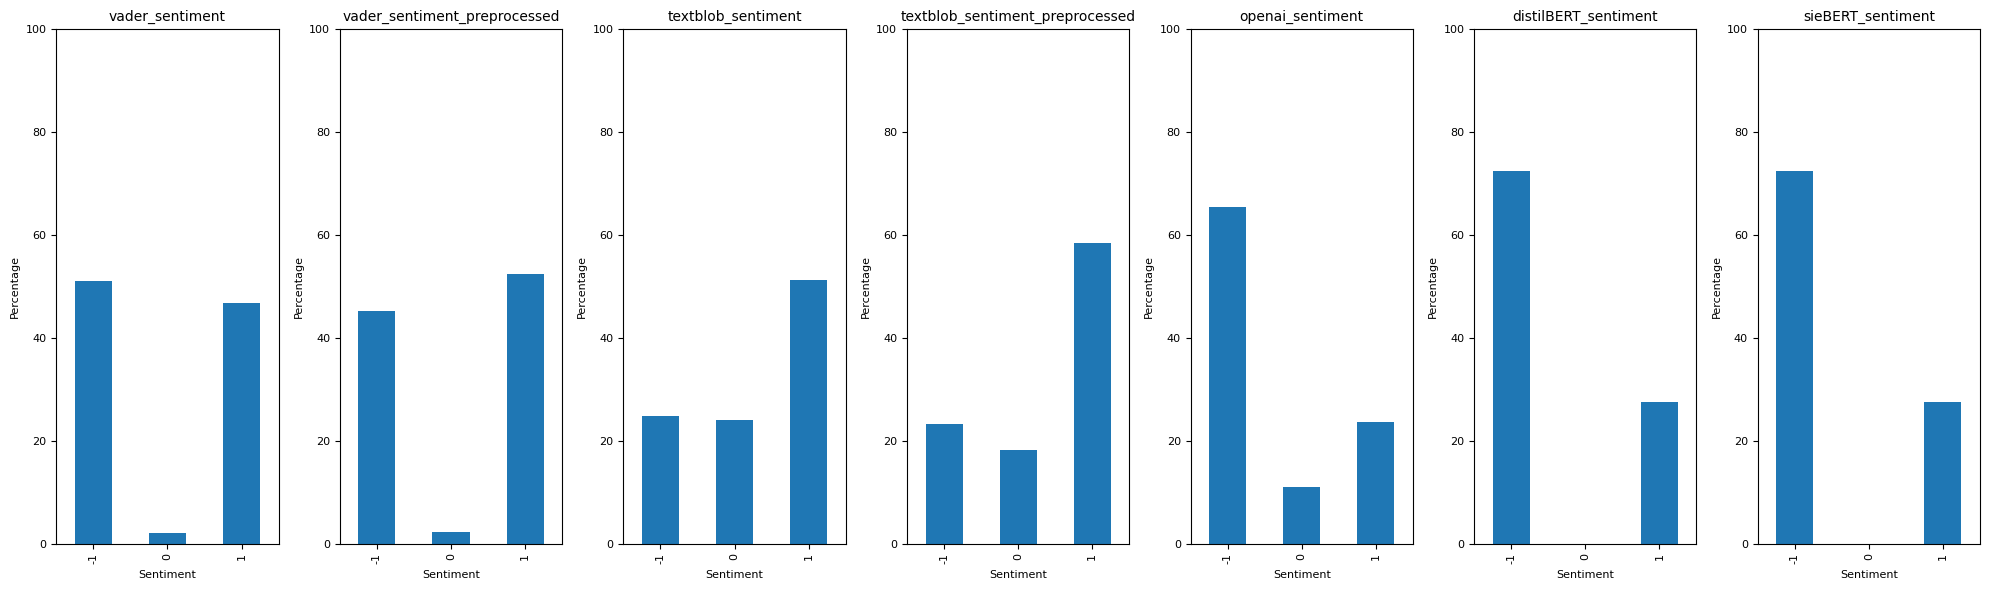

In [15]:
# Plot Sentiment Percentages
plot_sentiment_percentages(merged_sentiments_df)

##### Sentiment Distribution Across Different Models:

- **VADER Sentiment Analysis before/after preprocessing:**
  - The distributions show a fairly balanced sentiment distribution of positive and negative ratings, with minimal presence of neutral sentiments

- **TextBlob Sentiment Analysis before/after preprocessing:**
  - The sentiment distribution is balanced between negative and neutral reviews
  - The proportion of positive reviews is the greatest in both cases (before and after preprocessing), similar to the proportion of positive ones from the VADER analysis

- **OpenAI Sentiment Analysis:**
  - This model shows a strong negative sentiment distribution with over 60% of sentiments classified as negative

- **DistilBERT and SieBERT Sentiment Analysis:**
  - Both models also display a high proportion of negative sentiments (around 72.5%), with no neutral sentiment classification
  - Their distributions are similar to the OpenAI sentiment distribution (but of course without neutral ones)

- **Implications**:
  - You can expect that OpenAI, DistilBERT, and SieBERT will perform similarly in terms of accuracy, etc.


In [16]:
# Define the path to the labeled data CSV file
path = "../../outputs/nlp/sentiment_analysis/labeled_data_for_benchmark_analysis.csv"
# Read the labeled data into a DataFrame
labeled_data = pd.read_csv(path)

# Merge the labeled data with the merged sentiments DataFrame on the "Comment" column
# The merge is performed as an inner join to retain only the comments that are present in both DataFrames
analysis_df = pd.merge(labeled_data, merged_sentiments_df, on="Comment", how="inner")

In [17]:
# Define the sentiment columns
sentiment_columns = [
    "vader_sentiment", "vader_sentiment_preprocessed", "textblob_sentiment",
    "textblob_sentiment_preprocessed", "openai_sentiment", "distilBERT_sentiment",
    "sieBERT_sentiment"
]

# Calculate the metrics
metrics_df = calculate_metrics(analysis_df, "annotations", sentiment_columns)
metrics_df

,accuracy,precision,recall,f1_score
vader_sentiment,0.710021,0.510417,0.531371,0.510017
vader_sentiment_preprocessed,0.703625,0.562697,0.537292,0.517586
textblob_sentiment,0.550107,0.547352,0.516900,0.463088
textblob_sentiment_preprocessed,0.526652,0.507797,0.468399,0.423016
openai_sentiment,0.855011,0.734602,0.730220,0.719586
distilBERT_sentiment,0.842217,0.577917,0.596277,0.582067
sieBERT_sentiment,0.842217,0.577917,0.596277,0.582067


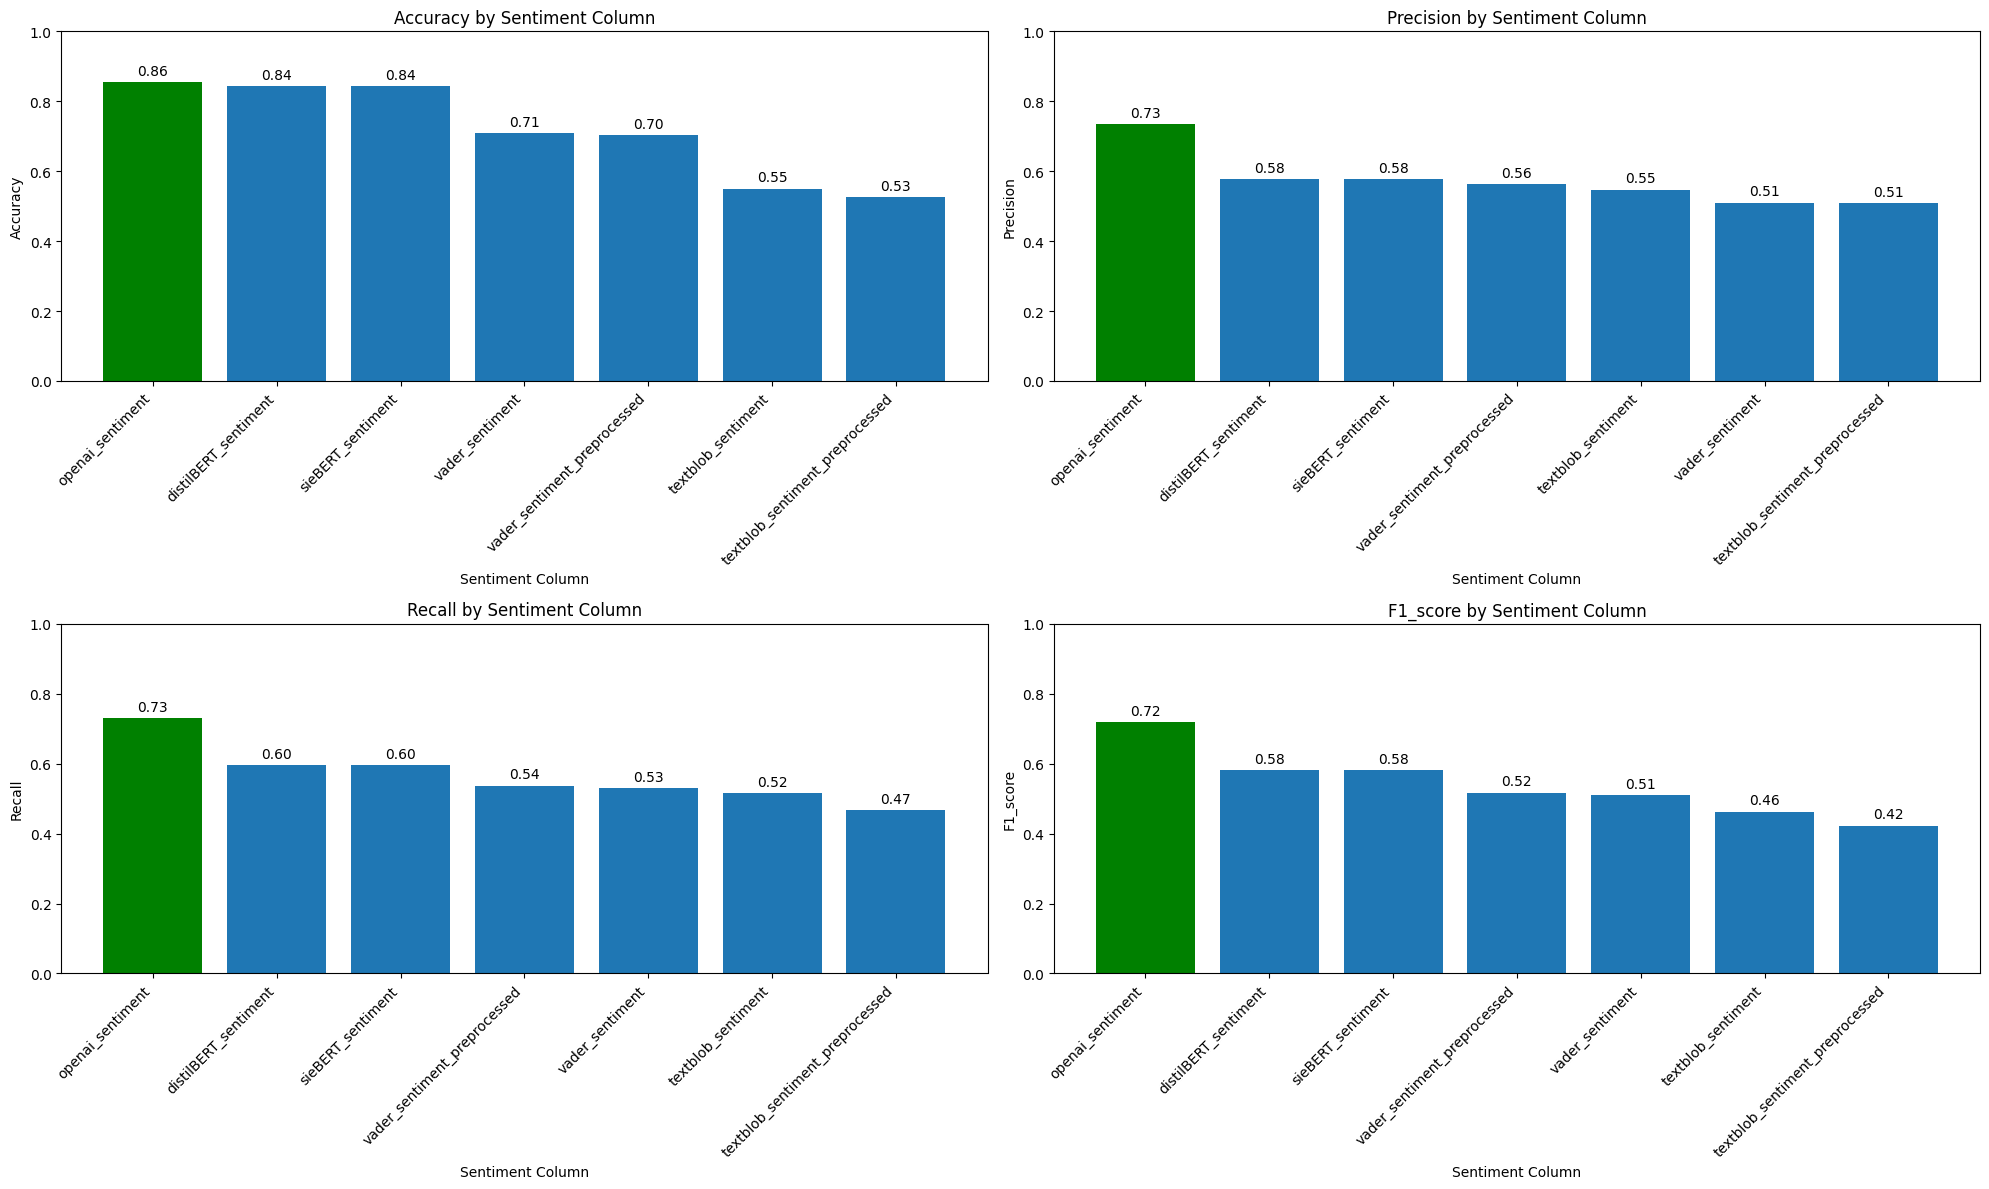

In [18]:
# Plot barplots per specific metric and mark the the best performing sentiment analysis
plot_metrics(metrics_df)

##### Performance Metrics by Sentiment Column:

- **OpenAI Analysis:**
  - OpenAI is the most suitable model, being the best in terms of accuracy, precision, recall, and F1 score

- **BERT and DistilBERT Models:**
  - These models perform similarly to OpenAI in terms of accuracy
  - However, they lag behind in other metrics (precision, recall, and F1 score)

- **TextBlob and VADER Models:**
  - These models are not the most suitable choices
  - They underperformed in all metrics
  - Additionally, they predicted a disproportionately high percentage of positive sentiments, which may explain the low scores
